In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import matplotlib.pyplot as plt

In [2]:
key = jax.random.PRNGKey(42)
m = 2000 #Antal datapunkter
layers = [1,10,1]
epochs = 1000

key, xkey, noisekey, wkey, bkey, thetakey = jax.random.split(key, 6)
x = jax.random.uniform(xkey, (1, m), minval = 0, maxval = 2 * jnp.pi)
f = lambda t : (jnp.exp(1j * 0.7 * t) + jnp.exp(1j * 0.3 * t)).real
f_map = vmap(f)
y = f_map(x) # + jax.random.normal(noisekey, (1, m)) * 0.3

In [35]:
def layer1(w, x):
    return jnp.dot(w.T, x)
    
def activation(w_dot_x):
    return jnp.exp(1j * w_dot_x)
    
def layer2(b, exp_w_dot_x):
    return jnp.dot(b, exp_w_dot_x)

def forward(w, b, x):
    return layer2(b, activation(layer1(w,x))).real

def get_b(w, x, y):
    A = activation(layer1(w,x)).T
    AT = jnp.conjugate(A).T
    ATA = jnp.dot(AT,A)
    ATA_inv = jnp.linalg.inv(ATA)
    ATy = jnp.dot(AT, y.T)
    b = jnp.dot(ATA_inv, ATy)
    return b.T

def get_p(b):
    return jnp.abs(b)/jnp.sum(jnp.abs(b))

def get_w(p_w, w):
    key = jax.random.PRNGKey(42)
    key, subkey = jax.random.split(key, 2)
    p_w = p_w.flatten()
    w = w.flatten()
    w_new = jax.random.choice(subkey, a = w, shape = w.shape, replace = False, p = p_w)[None, :] #lägger till dimension
    return w_new

def error(w, b, x,y):
    f = forward(w, b, x)
    e = f - y
    return jnp.mean(e**2)/2

In [69]:
nodes = 5
key, wkey, bkey, thetakey = jax.random.split(key, 4)
w = jax.random.normal(wkey, (1, nodes))
b = jax.random.normal(bkey, (1, nodes))

In [71]:
error_before_updating = error(w,b,x,y)
b_new = get_b(w,x,y)
error_after_updating = error(w,b_new,x,y)

In [73]:
print("before: ", error_before_updating)
print("after: ", error_after_updating)

#Bra eftersom att felet blir mindre ...?

before:  0.22462855
after:  2.2141116e-07


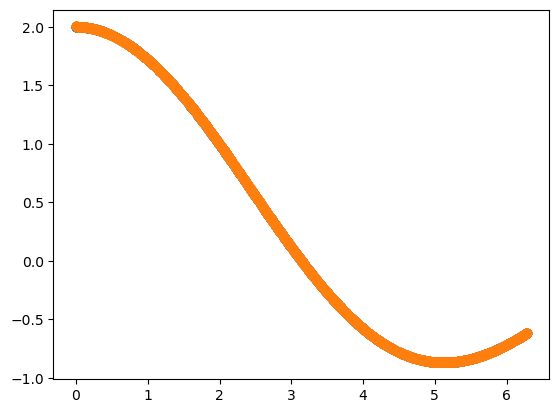

In [75]:
plt.scatter(x,y)
#plt.scatter(x, forward(w, b, x)) #innan vi uppdaterar b
plt.scatter(x, forward(w, b_new, x)) #efter vi uppdaterar b
#plt.scatter(x, (forward(w, b_new, x) - y)**2) #felet i kvadrat för varje punkt
plt.show()

In [77]:
error_list = []
p_w_history = []
b_history = []
w_history = []

delta = 0.05
for i in range(100):
    key, zetakey = jax.random.split(key, 2)
    zeta = jax.random.normal(thetakey, (1, nodes))
    w += delta * zeta
    b = get_b(w, x, y)
    b_history.append(b)
    
    error_list.append(error(w,b,x,y))
    
    p_w = get_p(b)
    
    p_w_history.append(p_w)
    
    #Hur vi får w kan vara fel
    w = get_w(p_w, w)
    w_history.append(w)
    
b = get_b(w, x, y)
error_list.append(error(w,b,x,y))

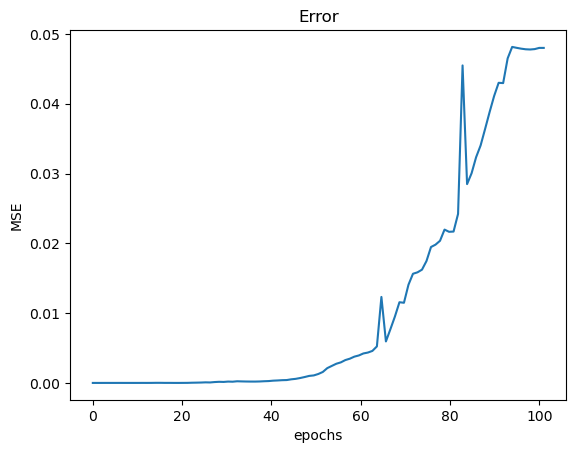

In [78]:
plt.plot(jnp.linspace(0, len(error_list), len(error_list)), error_list)
plt.title("Error")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.show()

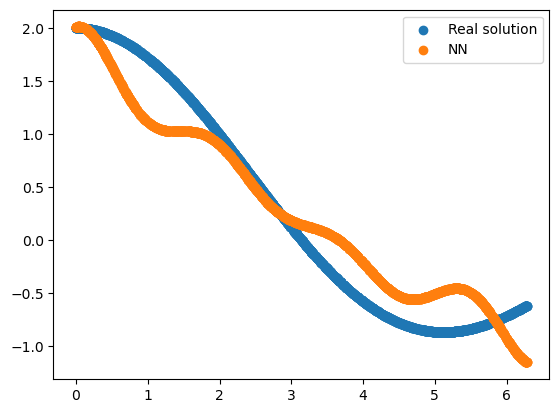

In [81]:
plt.scatter(x,y, label = "Real solution")
#plt.scatter(x, forward(w, b, x))
plt.scatter(x, forward(w, b, x), label = "NN")
plt.legend()
plt.show()

In [485]:
error_list[-1] #Felet sista epoch

Array(0.5818765, dtype=float32)

In [401]:
p_w
p_w = p_w.flatten()
p_w

Array([0.5907135 , 0.10672189, 0.24986686, 0.05269775], dtype=float32)

In [70]:
w
w = w.flatten()
w

Array([-5.430855  , -0.93711376], dtype=float32)

In [72]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key, 2)
w_new = jax.random.choice(subkey, a = w, shape = w.shape, replace = True, p = p_w)[None, :]

In [73]:
p_w

Array([0.5320421, 0.467958 ], dtype=float32)

In [76]:
w_new

Array([[-5.430855  , -0.93711376]], dtype=float32)

In [78]:
p_w = jnp.array([0.5, 0.5, 0, 0, 0])

In [79]:
w_new = jax.random.choice(subkey, a = w, shape = (1, 4), replace = True, p = p_w)[None, :]

In [81]:
w_new

Array([[[0.2684309, 0.5283718, 0.2684309, 0.5283718]]], dtype=float32)